# Extract data from jsons and insert into CSV

In [1]:
import os
import csv
import json


folder_path = '../receipts/json'

items = []

for file in os.listdir(folder_path):
    receipt_path = os.path.join(folder_path, file)

    with open(receipt_path) as receipt_data:
        receipt = json.load(receipt_data)

    item_list = receipt['itemList'] + receipt['discountList']

    for item in item_list:
        items.append([receipt['storeName'],item['itemName'],item['category']])

with open('../receipts/categories.csv', 'w', newline='') as file:
    header = [['store_name', 'item_name', 'category']]
    writer = csv.writer(file)
    writer.writerows(header+items)


# Clean and prep data

In [2]:
import pandas as pd
import string

def lower(text):
    result = " ".join([word.lower() for word in text.split()])
    return result

def remove_punctuation(product):
    text = str.maketrans((string.punctuation + '£'), ' '*len((string.punctuation + '£')))
    return product.translate(text)

def remove_nums(product):
    text = str.maketrans(string.digits, ' '*len(string.digits))
    return product.translate(text)

In [3]:
path = '../receipts/categories.csv'
dataset = pd.read_csv(path, header=0, index_col=0)

dataset = dataset.sample(657).reset_index()

print(dataset.shape)
dataset.head(10)

(657, 3)


,store_name,item_name,category
0,TESCO,SEASONAL VEG,groceries
1,LiDL,Frijj Cookie Dough,drinks
2,Sainsbury's,JS DBLE CHC COOKIES,snacks
3,TESCO,T.ZIPSEAL BAGS,homeware
4,TESCO,ICE CREAM,snacks
5,LiDL,Mackeral Sunflower,groceries
6,Sainsbury's,BLT SW,groceries
7,ALDI,THYME CUT,groceries
8,lidl,Green Tee Honey,drinks
9,TESCO,CC Kitchen towels,cleaning & laundry


## NLTK preprocesing

In [6]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop = stopwords.words('english')
stems = PorterStemmer()

def remove_stopwords_nltk(text):
    text = [word for word in text.split() if (word.lower() not in stop and len(word) > 1)]
    return " ".join(text)

def stemmer_nltk(text):
    stemmed = [stems.stem(word) for word in text.split()]
    return " ".join(stemmed)

In [7]:
stop = ['cc', 'wr', 'tesco', 'aa', 'ess']

units_solid = ['kg', 'g', 'gram', 'grams']
units_liquid = ['ml', 'l', 'cl', 'ltr']
units_length = ['m', 'mm', 'cm', 'km', 'metre']
units = ['pk', 'sm', 'lg', 'large', 'extra', 'sng']

def remove_stopwords(text):
    text = [word for word in text.split() if (word.lower() not in stop and len(word) > 1)]
    return " ".join(text)

def replace_units(text):
    words = []
    for word in text.split():
        if word in units_solid:
            words.append('<UNIT_SOLID>')
        elif word in units_liquid:
            words.append('<UNIT_LIQUID>')
        elif word in units:
            words.append('<UNIT>')
        else:
            words.append(word)
    return " ".join(words)

dataset['item_name'] = dataset['item_name'].astype(str)
dataset['item_name'] = dataset['item_name'].apply(lower)
dataset['item_name'] = dataset['item_name'].apply(remove_punctuation)
dataset['item_name'] = dataset['item_name'].apply(remove_nums)
dataset['item_name'] = dataset['item_name'].apply(replace_units)
dataset['item_name'] = dataset['item_name'].apply(remove_stopwords)
#dataset['item_name'] = dataset['item_name'].apply(stemmer_nltk)

dataset['store_name'] = dataset['store_name'].astype(str)
dataset['store_name'] = dataset['store_name'].apply(lower)
dataset['store_name'] = dataset['store_name'].apply(remove_punctuation)

print(dataset.head(10))

    store_name            item_name            category
0        tesco         seasonal veg           groceries
1         lidl   frijj cookie dough              drinks
2  sainsbury s  js dble chc cookies              snacks
3        tesco         zipseal bags            homeware
4        tesco            ice cream              snacks
5         lidl   mackeral sunflower           groceries
6  sainsbury s               blt sw           groceries
7         aldi            thyme cut           groceries
8         lidl      green tee honey              drinks
9        tesco       kitchen towels  cleaning & laundry


In [8]:
data = dataset.to_csv('../receipts/products_list_final.csv', encoding='utf-8')

In [9]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
from keras.utils import np_utils


def split_dataset(df):
    train, test, ytrain, ytest = train_test_split(df['item_name'].astype(str), df['category'], test_size=0.2, random_state=88)

    return train, test, ytrain, ytest


def create_labels(train_labels, test_labels, labels):
    encoder = LabelEncoder()

    encoder.fit(labels)

    y_train = encoder.transform(train_labels)
    y_val = encoder.transform(test_labels)

    return y_train, y_val, encoder
    

def create_one_hot_labels(Y_train, Y_test, labels):
    encoder = LabelEncoder()
    encoder.fit(labels)

    Y_train = encoder.transform(Y_train)
    Y_test = encoder.transform(Y_test)

    n_classes = np.max(Y_train) + 1

    Y_train = np_utils.to_categorical(Y_train, n_classes)
    Y_test = np_utils.to_categorical(Y_test, n_classes)

    return Y_train, Y_test, n_classes, encoder


def transform_data(train, val):
    vectorizer = CountVectorizer(max_features=5000)
    transformer = TfidfTransformer()

    X_train = vectorizer.fit_transform(train) # BoW
    X_train = transformer.fit_transform(X_train) # TF-IDF

    X_val = vectorizer.transform(val)
    X_val = transformer.transform(X_val)

    print(X_train.shape)

    return X_train, X_val


def get_svm_model(x,y):
    svm = LinearSVC(max_iter=1000).fit(x,y)
    return svm


def get_acc(m, x, y):
    predictions = m.predict(x)
    acc = np.mean(predictions == y)*100
    return acc

In [10]:
custom_data = pd.read_csv("../receipts/products_list_final.csv", index_col=0, header=0, names=["store_name", "item_name", "category"])
custom_labels = custom_data.category.unique()

In [11]:
custom_data

,store_name,item_name,category
0,tesco,seasonal veg,groceries
1,lidl,frijj cookie dough,drinks
2,sainsbury s,js dble chc cookies,snacks
3,tesco,zipseal bags,homeware
4,tesco,ice cream,snacks
...,...,...,...
652,tesco,yoghuts,snacks
653,lidl,organic vine tomato,groceries
654,lidl,bells ibuprofen,health & pharmacy
655,sushi jun,unagi cucumber roll,eating out


In [12]:
X_train, X_test, Y_train, Y_test = split_dataset(custom_data)

Y_train, Y_test, encoder = create_labels(Y_train, Y_test, custom_labels)

X_train, X_test = transform_data(X_train, X_test)

svm_model = get_svm_model(X_train, Y_train)

svm_acc = get_acc(svm_model, X_test, Y_test)


(525, 572)


In [14]:
svm_acc

79.54545454545455

(525, 563)
[[  5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   9   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   8   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  67   0   0   0   0   2   0   0   1   0   0   1]
 [  0   0   0   0   0  21   0   0   0   2   0   0   0   0   0   0]
 [  0   0   0   0   0   0   3   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  21   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   2   7   1   0   0 338   0   0   1   1   1   8]
 [  0   0   0   0   0   0   0   0   0   0   3   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  10   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   5   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  

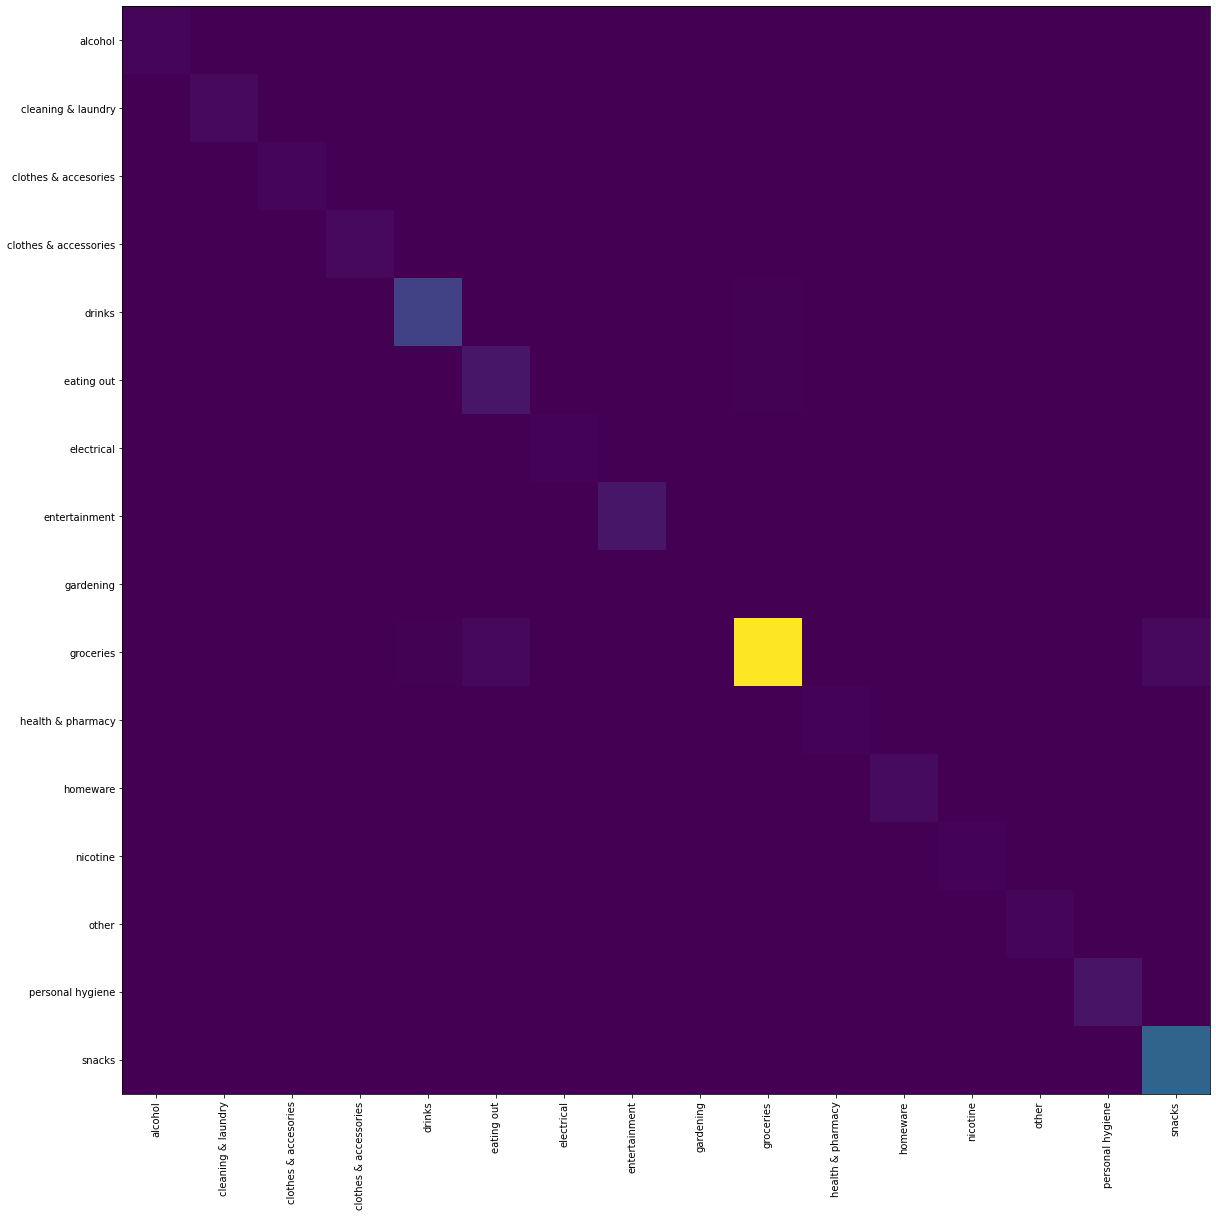

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

X_train, X_test, Y_train, Y_test = split_dataset(custom_data)

X_test = custom_data['item_name'].astype(str)
Y_test = custom_data['category']

Y_train, Y_test, encoder = create_labels(Y_train, Y_test, custom_labels)

X_train, X_test = transform_data(X_train, X_test)

svm_model = get_svm_model(X_train, Y_train)

predictions = svm_model.predict(X_test)

predictions = encoder.inverse_transform(predictions)
Y_test = encoder.inverse_transform(Y_test)

labels = encoder.classes_

cm = confusion_matrix(predictions, Y_test)
print(cm)
fig, ax = plt.subplots( figsize= (20, 20))

ax.imshow(cm)

ax.set_xticks(range(0, 16))
ax.set_yticks(range(0, 16))

ax.set_yticklabels(labels)
ax.set_xticklabels(labels, rotation='vertical')


plt.show()

In [14]:
X_train, X_test, Y_train, Y_test = split_dataset(custom_data)

Y_train, Y_test, encoder = create_labels(Y_train, Y_test, custom_labels)

X_train, X_test = transform_data(X_train, ['fried chicken', 'poems', 'biscuits', 'ice cream', 'vodka', 'lemon tea', 'lemon iced tea', 'lemon ice tea'])

svm_model = get_svm_model(X_train, Y_train)

#svm_acc = get_acc(svm_model, X_test, Y_test)

preds = svm_model.predict(X_test)

encoder.inverse_transform(preds)

(525, 563)


array(['eating out', 'groceries', 'groceries', 'snacks', 'groceries',
       'drinks', 'drinks', 'snacks'], dtype=object)

In [38]:
import imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline


In [27]:
oversample = SMOTE()

In [52]:
X_train = custom_data['item_name'].astype(str)
Y_train = custom_data['category']

encoder = LabelEncoder()

Y_train = encoder.fit_transform(Y_train)

In [53]:
Y_train.shape

(657,)

In [54]:
X_train.shape

(657,)

In [ ]:
sm = SMOTE(random_state=42) 
rm = RandomOverSampler(random_state=42)
my_pipe = make_pipeline(rm, sm) 
X_res, Y_res = my_pipe.fit_resample(X_train, Y_train)

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from keras.utils import np_utils
from keras.layers import TextVectorization
import keras.layers as l
import tensorflow as tf
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath

from keras.models import Sequential

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

mc = ModelCheckpoint(
    'final.h5',
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

es = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=100,
    mode='auto'
)

rlr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=50,
    min_delta=0.001,
    verbose=1, 
    mode='auto'
)

callbacks = [mc, es, rlr]

def split_dataset(df):
    train, test, ytrain, ytest = train_test_split(df['item_name'], df['category'], test_size=0.2, random_state=88)

    return train, test, ytrain, ytest
    

def create_one_hot_labels(Y_train, Y_test, labels):
    encoder = LabelEncoder()
    encoder.fit(labels)

    Y_train = encoder.transform(Y_train)
    Y_test = encoder.transform(Y_test)

    n_classes = np.max(Y_train) + 1

    Y_train = np_utils.to_categorical(Y_train, n_classes)
    Y_test = np_utils.to_categorical(Y_test, n_classes)

    return Y_train, Y_test, n_classes, encoder


def get_max_len(df):
    idx = df['item_name'].str.len().idxmax()
    print(idx)

    max_len = len(df["item_name"][idx])

    if max_len > 450:
        max_len = 500
    else:
        max_len += 50

    return max_len


def get_vectors(df, X_train, X_test, max_len):
    vectorizer = TextVectorization(output_sequence_length=max_len)

    vectorizer.adapt(df['item_name'])

    vocab = vectorizer.get_vocabulary()

    word_index = dict(zip(vocab, range(len(vocab))))

    X_train = vectorizer(X_train)
    X_test = vectorizer(X_test)

    return X_train, X_test, vocab, word_index, vectorizer


def get_embedding_model(matrix, n_tokens, max_len, n_classes, dim=100, lr=0.0003):
    embedding_layer = l.Embedding(
    n_tokens,
    dim,
    input_length=max_len,
    embeddings_initializer=tf.keras.initializers.Constant(matrix),
    trainable=True
    )

    embedding_model = Sequential()
    embedding_model.add(embedding_layer)
    embedding_model.add(l.GlobalMaxPooling1D()) # Turn 2D output into 1D for dense layers

    embedding_model.add(l.Dense(n_classes, activation='softmax'))

    optim = tf.keras.optimizers.Adam(learning_rate=lr)

    embedding_model.compile(
        loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy']
    )

    return embedding_model


def get_model_acc(X_train, X_test, Y_train, Y_test, model, n_epochs=1000):
    history = model.fit(X_train, Y_train, batch_size=25, epochs=n_epochs, validation_data=(X_test, Y_test), callbacks=callbacks)
    metrics = [[history.history['val_accuracy'][-1], history.history['val_loss'][-1]]]
    
    metrics = pd.DataFrame(metrics, columns=['val_accuracy', 'val_loss'])
    return metrics, history


def train_ft(df):
    cor_path = datapath("lee_background.cor")
    ft = FastText(vector_size=100)

    train_ft = df['item_name'].tolist()

    train_ft = [x.split() for x in train_ft]

    ft.build_vocab(corpus_file=cor_path)

    ft.train(
        corpus_file=cor_path, epochs=ft.epochs,
        total_examples=ft.corpus_count, total_words=ft.corpus_total_words,
    )

    ft.build_vocab(train_ft, update=True)
    ft.train(train_ft, total_examples=len(train_ft), epochs=ft.epochs)

    return ft


def get_ft_matrix(vocab, word_index, ft):
    n_tokens = len(vocab) + 2
    embedding_dim = 100
    hits = 0
    misses = 0

    matrix = np.zeros((n_tokens, embedding_dim))

    for word, i in word_index.items():
        try:
            embedding_vector = ft.wv[word]

            if embedding_vector is not None:
                matrix[i] = embedding_vector
                hits += 1
            else:
                matrix[i] = np.random.randn(embedding_dim)
                misses += 1
        except Exception as e:
            matrix[i] = np.random.randn(embedding_dim)
            print(e)
            misses += 1

    print("Converted %d words (%d misses)" % (hits, misses))

    return matrix, n_tokens

In [16]:
import matplotlib.pyplot as plt
def train_val_graph(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])

    plt.title(f'History of {metric} over epochs')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(['training '+metric, 'validation '+metric])

    plt.show()

In [17]:
def get_textcnn_model(matrix, n_tokens, max_len, n_classes, dim=100):
    inputs = tf.keras.Input(shape=(max_len,))

    embedding_layer = l.Embedding(
        n_tokens,
        dim,
        input_length=max_len,
        embeddings_initializer=tf.keras.initializers.Constant(matrix),
        trainable = True
    )(inputs)

    reshape = l.Reshape((max_len, 100, 1))(embedding_layer)

    conv_0 = l.Conv2D(100, kernel_size=(3,100), activation='relu')(reshape)
    conv_1 = l.Conv2D(100, kernel_size=(4,100), activation='relu')(reshape)
    conv_2 = l.Conv2D(100, kernel_size=(5,100), activation='relu')(reshape)

    maxpool_0 = l.MaxPooling2D(pool_size=(max_len - 3 + 1, 1))(conv_0)
    maxpool_1 = l.MaxPooling2D(pool_size=(max_len - 4 + 1, 1))(conv_1)
    maxpool_2 = l.MaxPooling2D(pool_size=(max_len - 5 + 1, 1))(conv_2)

    concatenate = l.Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])

    flatten = l.Flatten()(concatenate)

    dropout = l.Dropout(0.5)(flatten)

    output = l.Dense(n_classes, activation='softmax')(dropout)

    embedding_model = tf.keras.Model(inputs=inputs, outputs=output)

    optim = tf.keras.optimizers.Adam(learning_rate=0.0001)

    embedding_model.compile(
        loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy']
    )

    return embedding_model

In [414]:
def run_textcnn(df, labels):
    df['item_name'] = df['item_name'].astype(str)

    X_train, X_test, Y_train, Y_test = split_dataset(df)

    Y_train, Y_test, n_classes, encoder = create_one_hot_labels(Y_train, Y_test, labels)

    max_len = get_max_len(df)

    X_train, X_test, vocab, word_index, vectoriser = get_vectors(df, X_train, X_test, max_len)

    ft_embeddings = train_ft(df)

    ft_matrix, n_tokens = get_ft_matrix(vocab, word_index, ft_embeddings)

    print(n_tokens, max_len)

    ft_model = get_textcnn_model(ft_matrix, n_tokens, max_len, n_classes)
    
    metrics, history = get_model_acc(X_train, X_test, Y_train, Y_test, ft_model)
    
    return metrics, history, vectoriser, encoder

149
Converted 611 words (0 misses)
613 113
Epoch 1/1000
21/21 [==============================] - 1s 24ms/step - loss: 2.6755 - accuracy: 0.4648 - val_loss: 2.5699 - val_accuracy: 0.5455 - lr: 1.0000e-04
Epoch 2/1000
21/21 [==============================] - 0s 5ms/step - loss: 2.5006 - accuracy: 0.5162 - val_loss: 2.3887 - val_accuracy: 0.5455 - lr: 1.0000e-04
Epoch 3/1000
21/21 [==============================] - 0s 5ms/step - loss: 2.3237 - accuracy: 0.5162 - val_loss: 2.2266 - val_accuracy: 0.5455 - lr: 1.0000e-04
Epoch 4/1000
21/21 [==============================] - 0s 5ms/step - loss: 2.2160 - accuracy: 0.5162 - val_loss: 2.0982 - val_accuracy: 0.5455 - lr: 1.0000e-04
Epoch 5/1000
21/21 [==============================] - 0s 4ms/step - loss: 2.1126 - accuracy: 0.5162 - val_loss: 2.0128 - val_accuracy: 0.5455 - lr: 1.0000e-04
Epoch 6/1000
21/21 [==============================] - 0s 4ms/step - loss: 2.0395 - accuracy: 0.5162 - val_loss: 1.9506 - val_accuracy: 0.5455 - lr: 1.0000e-04
Ep

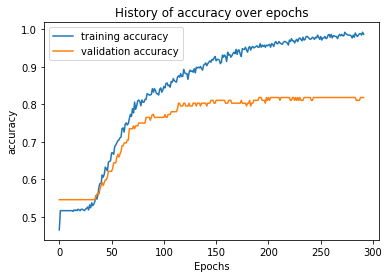

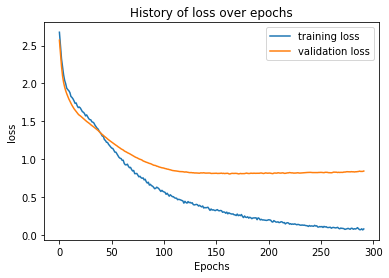

In [415]:
metrics, history, vectoriser, encoder = run_textcnn(custom_data, custom_labels)

train_val_graph(history, "accuracy")
train_val_graph(history, "loss")

In [419]:
model = load_model('final.h5')

model.summary()

test_string = tf.keras.Input(shape=(1,), dtype="string")

x = vectoriser(test_string)

class_names = encoder.classes_

preds = model(x)

test_model = tf.keras.Model(test_string, preds)

test_items = [['fried chicken'], ['poems'], ['biscuits'], ['ice cream'], ['vodka'], ['lemon tea'], ['lemon iced tea'], ['lemon ice tea']]

probabilities = test_model.predict(test_items)

for i in tf.range(len(probabilities)):
    print(test_items[i][0] + " is labelled with the category \"" + class_names[np.argmax(probabilities[i])] + "\" with " + str(float('{0:.2f}'.format(np.max(probabilities[i])*100))) + "% certainty")

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 113)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 113, 100)     61300       ['input_13[0][0]']               
                                                                                                  
 reshape_2 (Reshape)            (None, 113, 100, 1)  0           ['embedding_2[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)              (None, 111, 1, 100)  30100       ['reshape_2[0][0]']              
                                                                                            

In [18]:
custom_stores = custom_data.store_name.unique()

In [19]:
custom_stores

array(['tesco', 'lidl', 'sainsbury s', 'aldi', 'waitrose   partners',
       't k maxx', 'boots uk limited', 'sushi jun', 'whlung supermarket',
       'uniqlo', 'uber eats', 'taco bell', 'vapouriz', 'oxfam',
       'blue bear bookshop', 'evapo', 'poundland', 'aldi stores',
       'simply fresh', 't4', 'b m', 'kenji', 'www itsu com', 'greggs',
       'tea terrace', 'osprey london', 't a shake shack', 'costa',
       'house of fraser', 'currys pc world', 'co op', 'bodycare'],
      dtype=object)

In [20]:
def load_stores(X2_train, X2_test, stores):
    encoder = LabelEncoder()
    encoder.fit(stores)

    X2_train = encoder.transform(X2_train)
    X2_test = encoder.transform(X2_test)

    n_stores = np.max(X2_train) + 1

    X2_train = np_utils.to_categorical(X2_train, n_stores)
    X2_test = np_utils.to_categorical(X2_test, n_stores)

    stores_shape = len(X2_train[0])

    return X2_train, X2_test, stores_shape

In [21]:
def split_dataset2(df):
    train, test, x2train, x2test, ytrain, ytest = train_test_split(df['item_name'].astype(str), df['store_name'], df['category'], test_size=0.2, random_state=88)

    return train, test, x2train, x2test, ytrain, ytest

In [22]:
def get_store_vectors(df, X2_train, X2_test, max_len):
    vectorizer = TextVectorization(output_sequence_length=max_len)

    vectorizer.adapt(df['store_name'])

    vocab = vectorizer.get_vocabulary()

    word_index = dict(zip(vocab, range(len(vocab))))

    X2_train = vectorizer(X2_train)
    X2_test = vectorizer(X2_test)

    print(len(X2_train[0]))

    return X2_train, X2_test, vocab, word_index, vectorizer

In [23]:
def get_textcnn2_model(matrix, n_tokens, store_tokens, max_len, n_classes, dim=100):
    product_inputs = tf.keras.Input(shape=(max_len,))
    
    product_embedding = l.Embedding(
        n_tokens,
        dim,
        input_length=max_len,
        embeddings_initializer=tf.keras.initializers.Constant(matrix),
        trainable = True
    )(product_inputs)
    
    store_inputs = tf.keras.Input(shape=(50,))

    store_embedding = l.Embedding(
        store_tokens,
        dim,
        input_length=50,
        trainable = True
    )(store_inputs)

    reshape = l.Reshape((max_len, 100, 1))(product_embedding)
    pooled = l.GlobalMaxPooling1D()(store_embedding)

    conv_0 = l.Conv2D(100, kernel_size=(3,100), activation='relu')(reshape)
    conv_1 = l.Conv2D(100, kernel_size=(4,100), activation='relu')(reshape)
    conv_2 = l.Conv2D(100, kernel_size=(5,100), activation='relu')(reshape)

    maxpool_0 = l.MaxPooling2D(pool_size=(max_len - 3 + 1, 1))(conv_0)
    maxpool_1 = l.MaxPooling2D(pool_size=(max_len - 4 + 1, 1))(conv_1)
    maxpool_2 = l.MaxPooling2D(pool_size=(max_len - 5 + 1, 1))(conv_2)

    concatenate = l.Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])

    flatten = l.Flatten()(concatenate)

    concatenate = l.Concatenate(axis=1)([flatten,pooled])

    dropout = l.Dropout(0.5)(concatenate)

    dense1 = l.Dense(128, activation='relu')(dropout)

    dropout2 = l.Dropout(0.5)(dense1)

    output = l.Dense(n_classes, activation='softmax')(dropout2)

    embedding_model = tf.keras.Model(inputs=[product_inputs, store_inputs], outputs=output)

    optim = tf.keras.optimizers.Adam(learning_rate=0.0001)

    embedding_model.compile(
        loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy']
    )

    return embedding_model

In [24]:
def get_model_acc2(X_train, X_test, X2_train, X2_test, Y_train, Y_test, model, n_epochs=1000):
    history = model.fit([X_train, X2_train],Y_train, batch_size=25, epochs=n_epochs, validation_data=([X_test, X2_test], Y_test), callbacks=callbacks)
    metrics = [[history.history['val_accuracy'][-1], history.history['val_loss'][-1]]]
    
    metrics = pd.DataFrame(metrics, columns=['val_accuracy', 'val_loss'])
    return metrics, history

In [25]:
def run_storedata(df, labels):
    df['item_name'] = df['item_name'].astype(str)

    X_train, X_test, X2_train, X2_test, Y_train, Y_test = split_dataset2(df)

    Y_train, Y_test, n_classes, encoder = create_one_hot_labels(Y_train, Y_test, labels)

    max_len = get_max_len(df)
    print(max_len)

    X_train, X_test, vocab, word_index, vectoriser = get_vectors(df, X_train, X_test, max_len)
    X2_train, X2_test, store_vocab, _, store_vectoriser = get_store_vectors(df, X2_train, X2_test, max_len=50)

    ft_embeddings = train_ft(df)

    ft_matrix, n_tokens = get_ft_matrix(vocab, word_index, ft_embeddings)

    store_tokens = len(store_vocab)

    print(n_tokens, max_len)

    model = get_textcnn2_model(ft_matrix, n_tokens, store_tokens, max_len, n_classes)
    
    metrics, history = get_model_acc2(X_train, X_test, X2_train, X2_test, Y_train, Y_test, model)
    
    return metrics, history, model, encoder, vectoriser, store_vectoriser

In [1]:
metrics, history, model, encoder, vectoriser, store_vectoriser = run_storedata(custom_data, custom_labels)

train_val_graph(history, "accuracy")
train_val_graph(history, "loss")

NameError: name 'run_storedata' is not defined

In [ ]:
import pickle

In [ ]:
outfile = open('encoder', 'wb')

pickle.dump(encoder, outfile)

outfile.close

In [ ]:
outfile = open('vectoriser', 'wb')

pickle.dump(vectoriser, outfile)

outfile.close

In [36]:
from keras import backend as K
K.clear_session()

In [37]:
from keras.models import load_model
K.clear_session()
model = load_model('final.h5')

In [38]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 120)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 120, 100)     67100       ['input_3[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 120, 100, 1)  0           ['embedding_2[0][0]']            
                                                                                                  
 conv2d_3 (Conv2D)              (None, 118, 1, 100)  30100       ['reshape_1[0][0]']              
                                                                                            

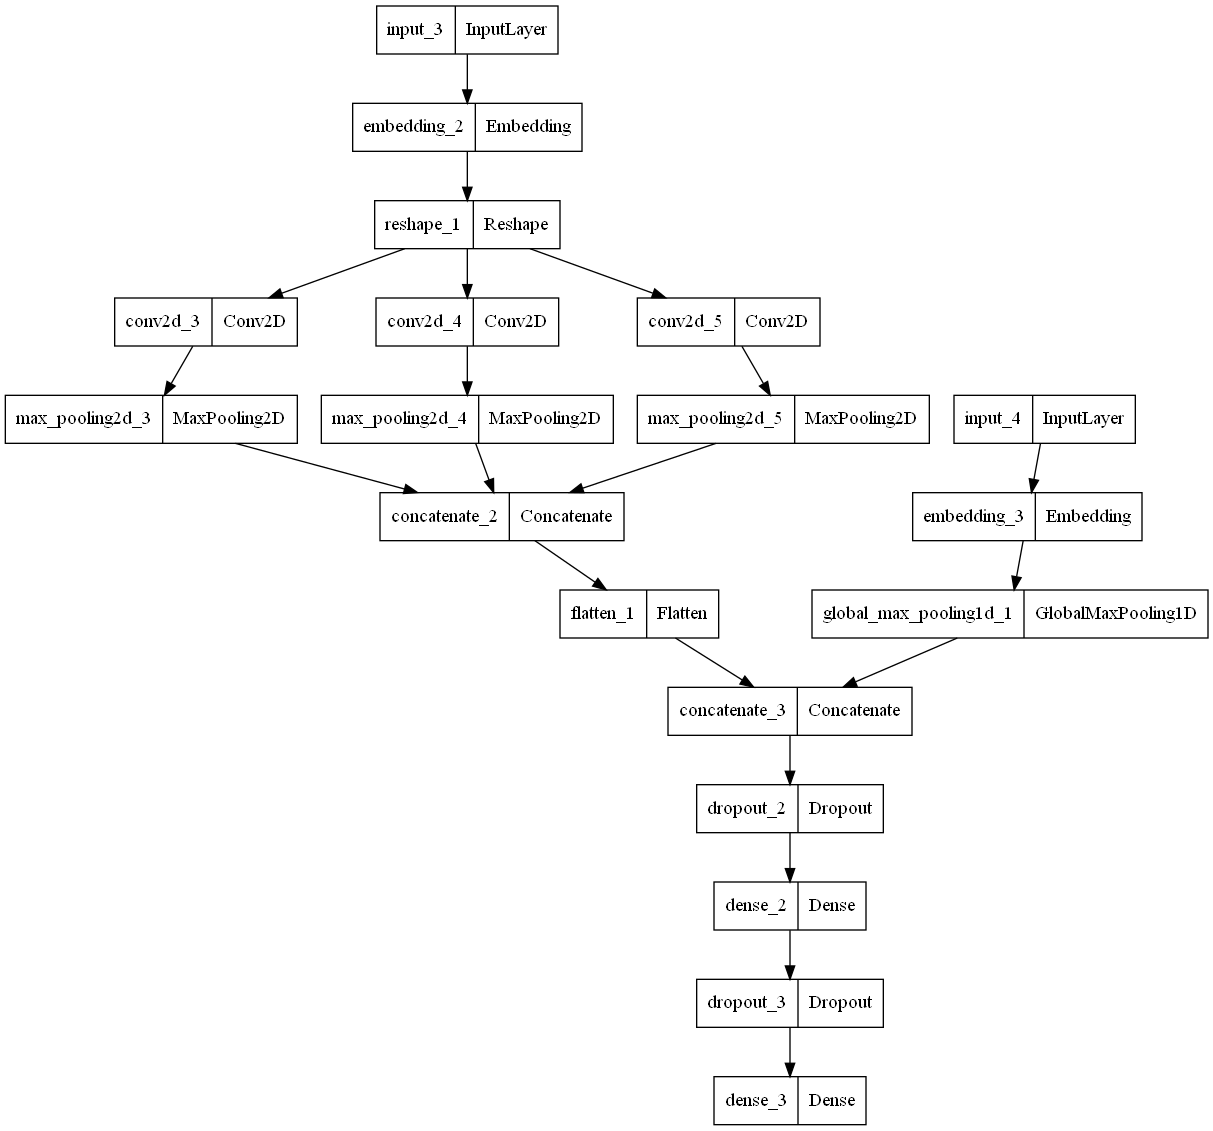

In [39]:
tf.keras.utils.plot_model(model)

In [40]:
items = [
    ['fried chicken'],
    ['poems'],
    ['biscuits'],
    ['ice cream'],
    ['vodka'],
    ['lemon tea'],
    ['lemon iced tea'],
    ['lemon ice tea'],
    ['fried chicken'],
    ['poems'],
    ['biscuits'],
    ['ice cream'],
    ['vodka'],
    ['lemon tea'],
    ['lemon iced tea'],
    ['lemon ice tea']
    ]
    
stores = [
    ['t4'],
    ['book shop'],
    ['tesco'],
    ['tesco'],
    ['sainsburys'],
    ['aldi'],
    ['lidl'],
    ['t4'],
    ['tesco'],
    ['tesco'],
    ['sainsburys'],
    ['asda'],
    ['tesco'],
    ['tesco'],
    ['tesco'],
    ['tesco']
    ]

In [41]:
product_string = tf.keras.Input(shape=(1,), dtype="string")
store_string = tf.keras.Input(shape=(1,), dtype="string")

x = vectoriser(product_string)
x2 = store_vectoriser(store_string)

class_names= encoder.classes_

predictions = model([x, x2])


e2e_model = tf.keras.Model([product_string, store_string], predictions)

#e2e_model.summary()

products_input = tf.convert_to_tensor(items)
store_input = tf.convert_to_tensor(stores)


probabilities = e2e_model.predict([products_input, store_input])

for i in tf.range(len(probabilities)):
    print("'"+products_input.numpy()[i][0].decode('UTF-8') + "' from '" + store_input.numpy()[i][0].decode('UTF-8') + "' is labelled with the category \"" + class_names[np.argmax(probabilities[i])] + "\" with " + str(float('{0:.2f}'.format(np.max(probabilities[i])*100))) + "% certainty")

'fried chicken' from 't4' is labelled with the category "eating out" with 80.56% certainty
'poems' from 'book shop' is labelled with the category "snacks" with 20.78% certainty
'biscuits' from 'tesco' is labelled with the category "snacks" with 98.2% certainty
'ice cream' from 'tesco' is labelled with the category "snacks" with 99.98% certainty
'vodka' from 'sainsburys' is labelled with the category "snacks" with 20.78% certainty
'lemon tea' from 'aldi' is labelled with the category "drinks" with 99.64% certainty
'lemon iced tea' from 'lidl' is labelled with the category "drinks" with 99.93% certainty
'lemon ice tea' from 't4' is labelled with the category "drinks" with 96.87% certainty
'fried chicken' from 'tesco' is labelled with the category "groceries" with 93.39% certainty
'poems' from 'tesco' is labelled with the category "snacks" with 62.55% certainty
'biscuits' from 'sainsburys' is labelled with the category "snacks" with 91.87% certainty
'ice cream' from 'asda' is labelled wit